## Making visualisations of our groups from non-XMM X-ray telescopes

This notebook is largely to give context as to the other X-ray data available for these systems - which in some cases might be used for analyses for this work, but in others will just be used for the images displayed in this notebook.

### Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM
import os
from shutil import rmtree

from tqdm import tqdm

import xga
# This just sets the number of cores this analysis is allowed to use
xga.NUM_CORES = 20
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/visualisation/')[0]+'xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
# As currently XGA will setup an xga_output directory in our current directory, I remove it to keep it all clean
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.products import Image, ExpMap, RateMap
from xga.imagetools.misc import pix_rad_to_physical, physical_rad_to_pix

%matplotlib inline

## Setting up the storage directory

We save the visualisations generated in this notebook to disk, so they can be easily viewed. We ensure that the storage directory exists, and if it doesn't then we create it:

In [2]:
if not os.path.exists('../../outputs/figures/xray_ims/non_xmm/'):
    os.makedirs('../../outputs/figures/xray_ims/non_xmm/')

## Setting up a cosmology

A cosmology is required to convert from pixels to degrees to kpc, so we select an concordance flat LambdaCDM model:

In [3]:
cosmo = LambdaCDM(70, 0.3, 0.7)

## Defining useful constants

Here we put any useful quantities that are constant:

In [4]:
# The half-side-length of the zoomed-in images we make later
half_side_len = Quantity(500, 'kpc')

## Read in the sample file

Here we use Pandas to read in the notebook containing the locations of the groups that we are interested in:

In [5]:
samp = pd.read_csv('../../sample_files/init_group_info.csv')
samp

name      est_ra    est_dec  redshift
0    25124  243.629055  26.730240     0.186
1    44739  229.793620  28.331750     0.118
2   19670A  150.256710  50.793942     0.134
3   19670B  150.214920  50.805014     0.134
4    12833  129.496800  44.248700     0.145
5    44858  230.112000  28.887750     0.127
6  PHL1811  328.769920  -9.588805     0.077
7    50433  157.758000  30.862000     0.136

## Non-XMM X-ray telescope visualisations

Here we create whole FoV, and zoomed-in source specific, visualisations of the non-XMM data that may be relevant for some of our groups. The locations of groups are marked by white cross-hairs. It is possible that some groups will be off the field of view, and the observations were selected because DAXA searched within some radius based on the approximate size of the detector on the sky.

### Chandra

We could load the DAXA archive to see what Chandra data there are, but instead we just list the sub-directories in the Chandra raw data directory to get a list of ObsIDS - we will iterate through these.

In [6]:
chandra_obs_ids = os.listdir('../../data/chandra_raw')
chandra_obs_ids

['21564', '4791', '15378', '2957', '2958', '15357', '22035']

As we downloaded the Chandra data with `download_standard=True` we will have acquired pre-processed images, and can view them with XGA image objects. That just involves setting up an XGA image with the path to the fits file, the name of the instrument, and the energy bounds (0.5-7.0 keV) for the pre-processed images:

12833


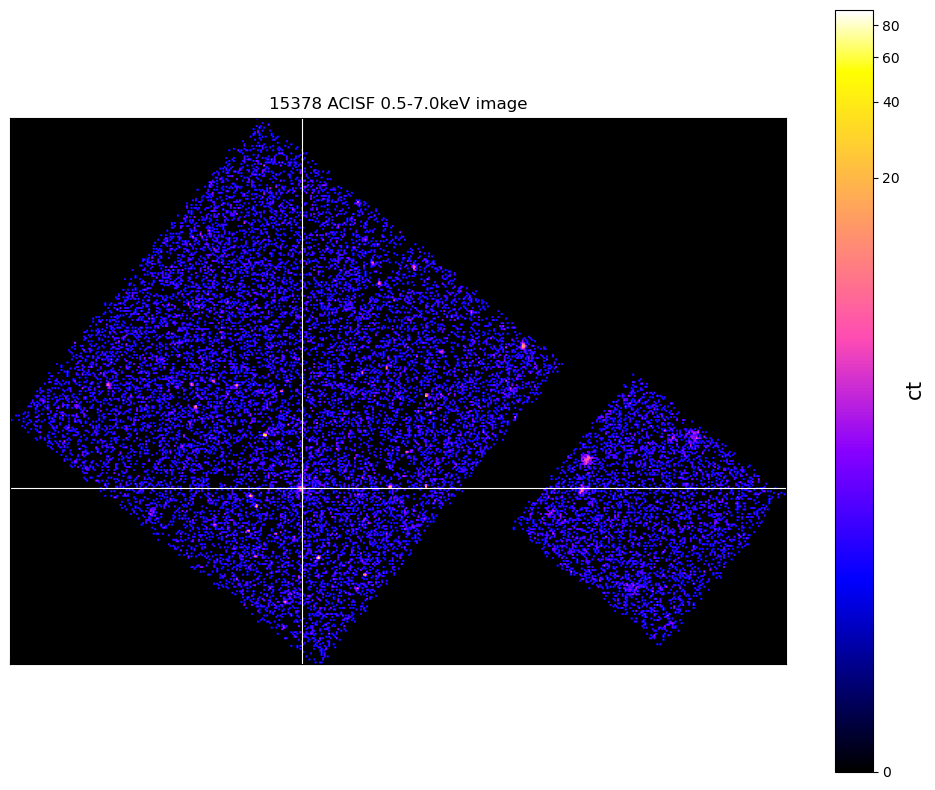

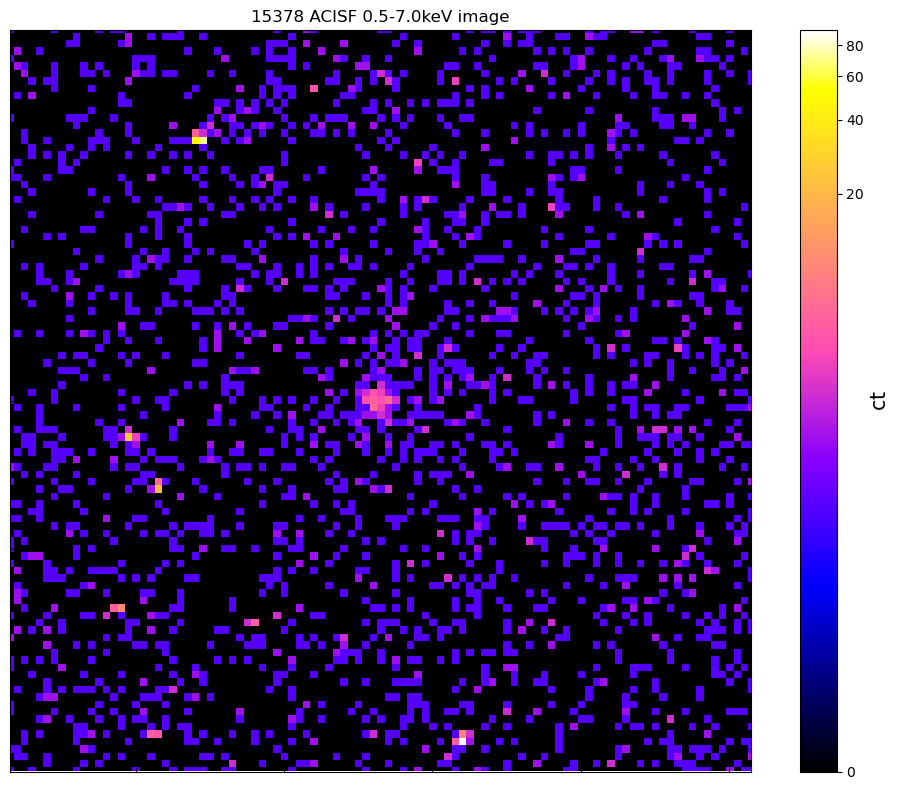





PHL1811


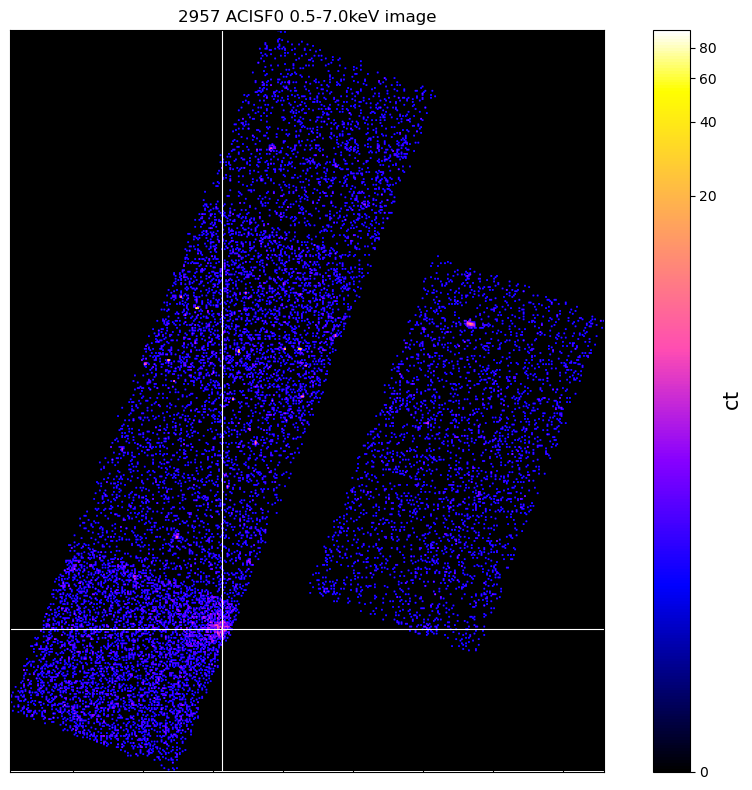

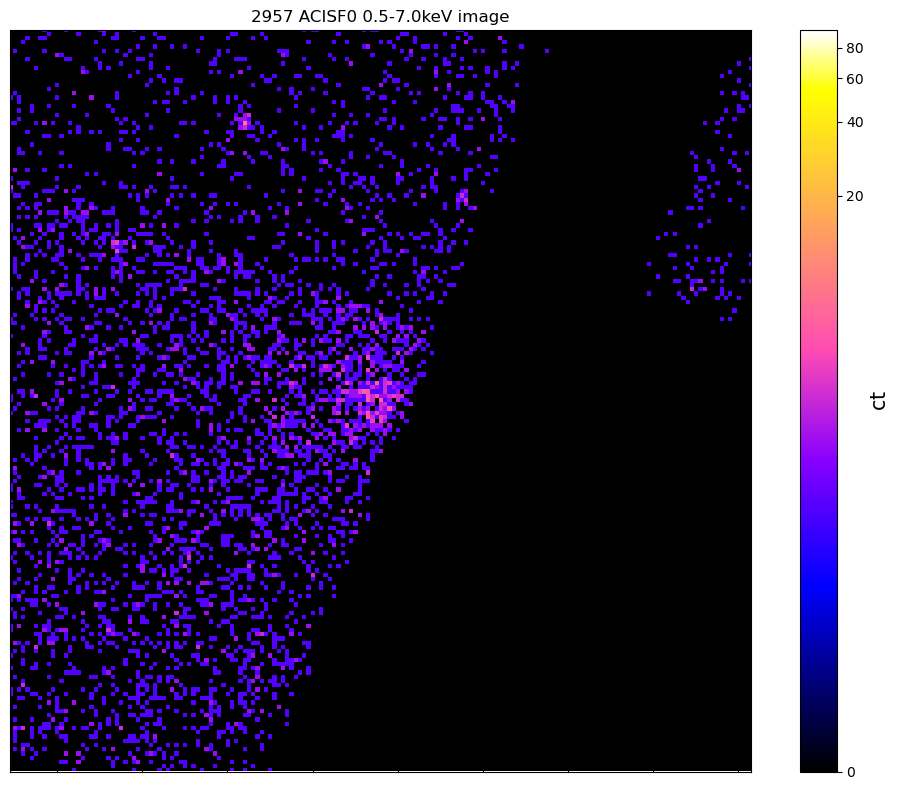





PHL1811


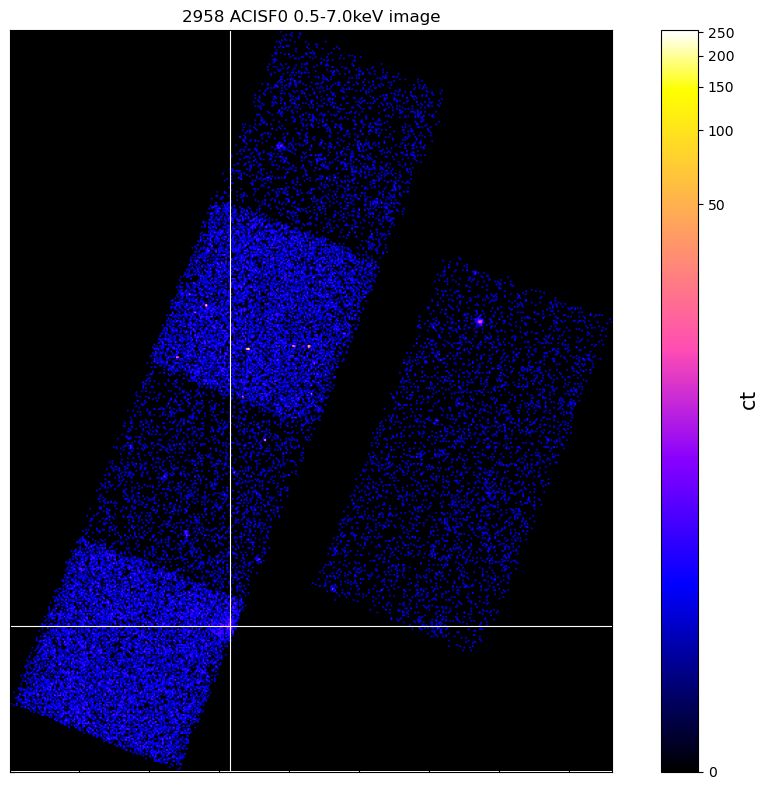

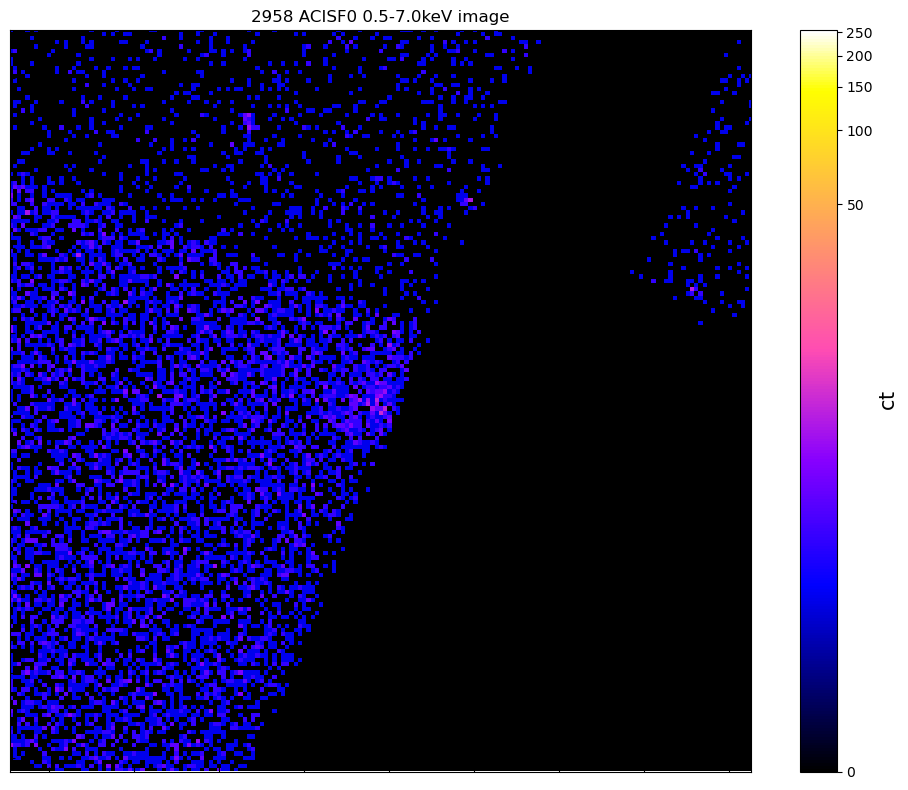

In [7]:
for oi in chandra_obs_ids:
    # The top level data path for the current Chandra ObsID
    data_path = '../../data/chandra_raw/{oi}/primary/'.format(oi=oi)
    # Finding the full FoV image file
    im_file_name = [f for f in os.listdir(data_path) if 'full_img' in f][0]
    # The full path to the full FoV image
    im_file_path = data_path + im_file_name
    # Set up the XGA image, includes splitting the file name to retrieve the instrument used
    inst = im_file_name.split(oi)[0]
    cur_im = Image(im_file_path, oi, inst, '', '', '', 
                   Quantity(0.5, 'keV'), Quantity(7.0, 'keV'))
    
    # We try to convert the coordinates for each group to pixels of the current image, the majority will fail
    #  because the pixel coordinates calculated aren't valid, so the ones that don't error can be plotted
    for row_ind, row in samp.iterrows():
        # Reading out the relevant coordinate for the current group
        cur_coord = Quantity(row[['est_ra', 'est_dec']], 'deg')
        cur_z = row['redshift']
        try:
            # We try to convert the coordinate, and if that doesn't fail then we'll move onto printing
            #  the group name and plotting the image
            cur_im.coord_conv(cur_coord, 'pix')
            print(row['name'])
            cur_im.view(cur_coord, zoom_in=True)
            im_pth = '../../outputs/figures/xray_ims/non_xmm/{n}_chandra_{o}_{i}_fov.png'.format(n=row['name'], 
                                                                                                 i=inst, 
                                                                                                 o=oi)
            cur_im.save_view(im_pth, cur_coord, zoom_in=True)
            
            cur_coord_pix = cur_im.coord_conv(cur_coord, 'pix')
            half_side_len_pix = physical_rad_to_pix(cur_im, half_side_len, cur_coord, 
                                                    cur_z, cosmo).value
            
            im_pth = '../../outputs/figures/xray_ims/non_xmm/{n}_chandra_{o}_{i}_'\
                '{sl}.png'.format(n=row['name'], i=inst, sl=str(half_side_len*2).replace(' ', ''), o=oi)
            
            # We also make a nice zoomed-in cutout, with a side length equal to half_side_len x 2
            cur_im.view(manual_zoom_xlims=[cur_coord_pix[0].value-half_side_len_pix, 
                                           cur_coord_pix[0].value+half_side_len_pix], 
                        manual_zoom_ylims=[cur_coord_pix[1].value-half_side_len_pix, 
                                           cur_coord_pix[1].value+half_side_len_pix], zoom_in=True)
            cur_im.save_view(im_pth, 
                             manual_zoom_xlims=[cur_coord_pix[0].value-half_side_len_pix, 
                                                cur_coord_pix[0].value+half_side_len_pix], 
                             manual_zoom_ylims=[cur_coord_pix[1].value-half_side_len_pix, 
                                                cur_coord_pix[1].value+half_side_len_pix], zoom_in=True)
            print('\n\n\n')
        except ValueError as err:
            pass

### ROSAT Pointed

We find which ROSAT pointed ObsIDs have been acquired in the same way we did for Chandra:

In [8]:
rp_obs_ids = os.listdir('../../data/rosat_pointed_raw/')
rp_obs_ids

['RP800350N00', 'RH701869N00', 'RP700433N00', 'RH800762N00', 'RF700433N00']

50433


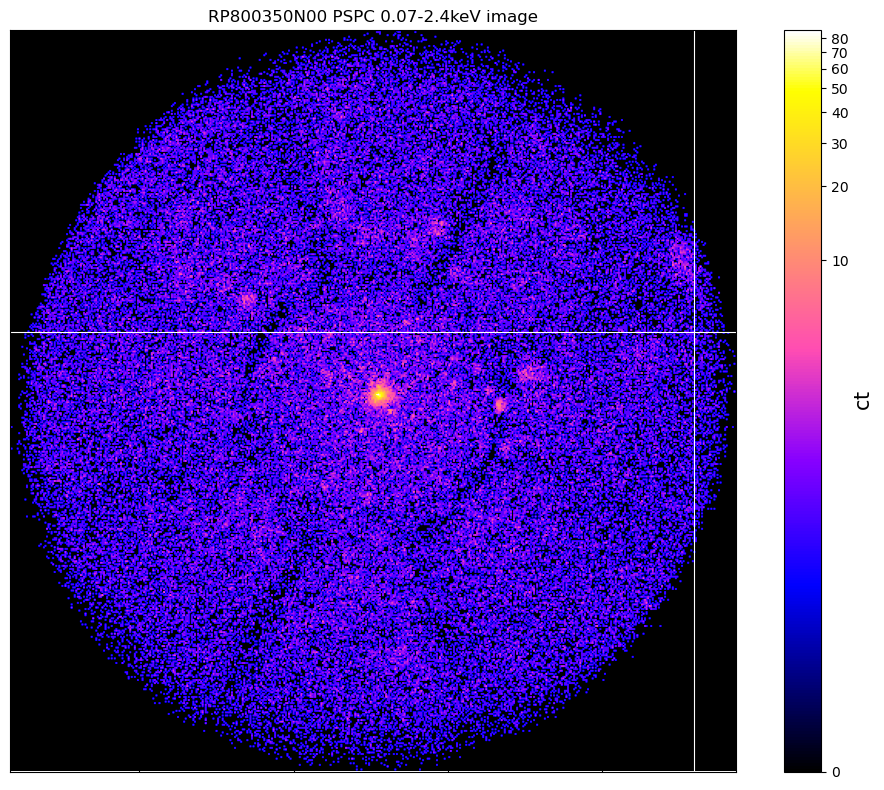

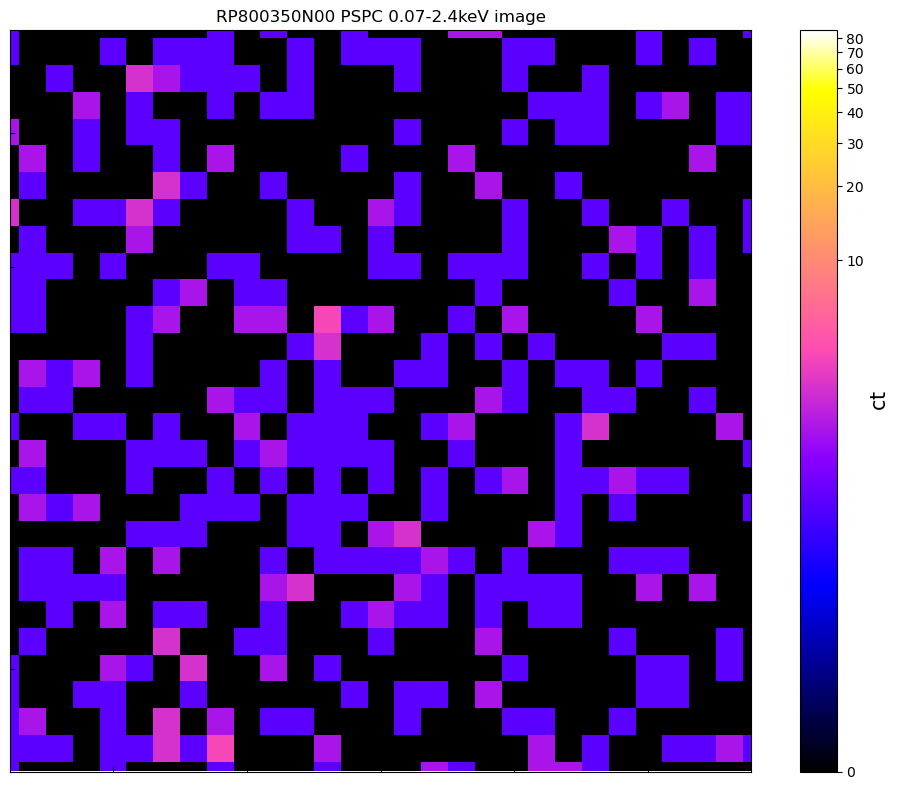





19670A


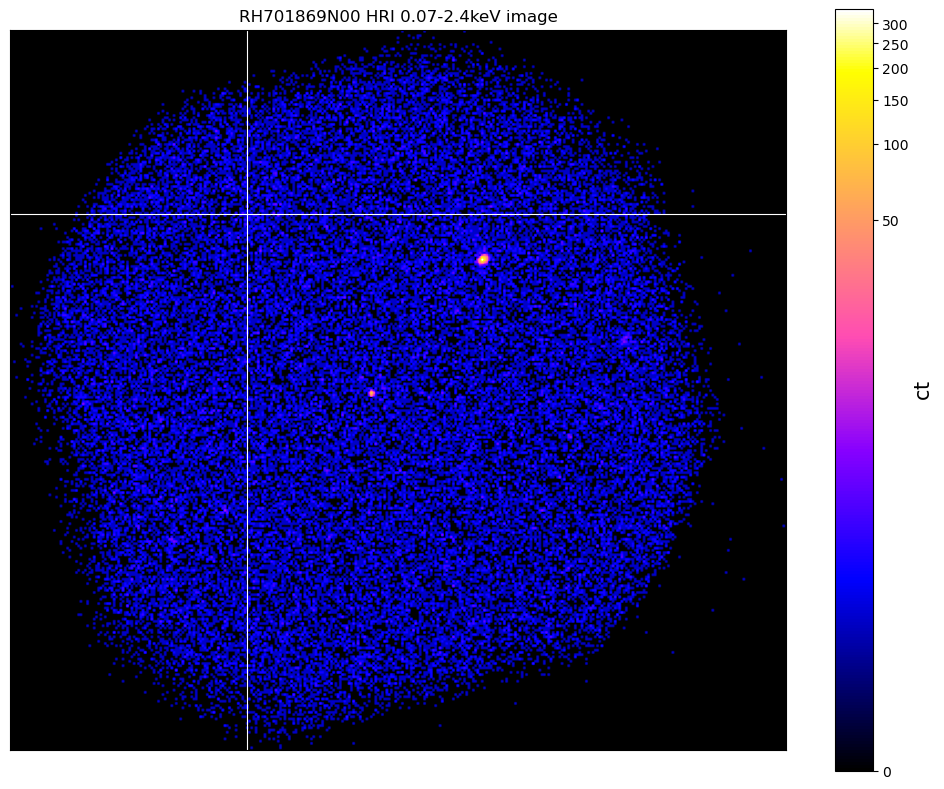

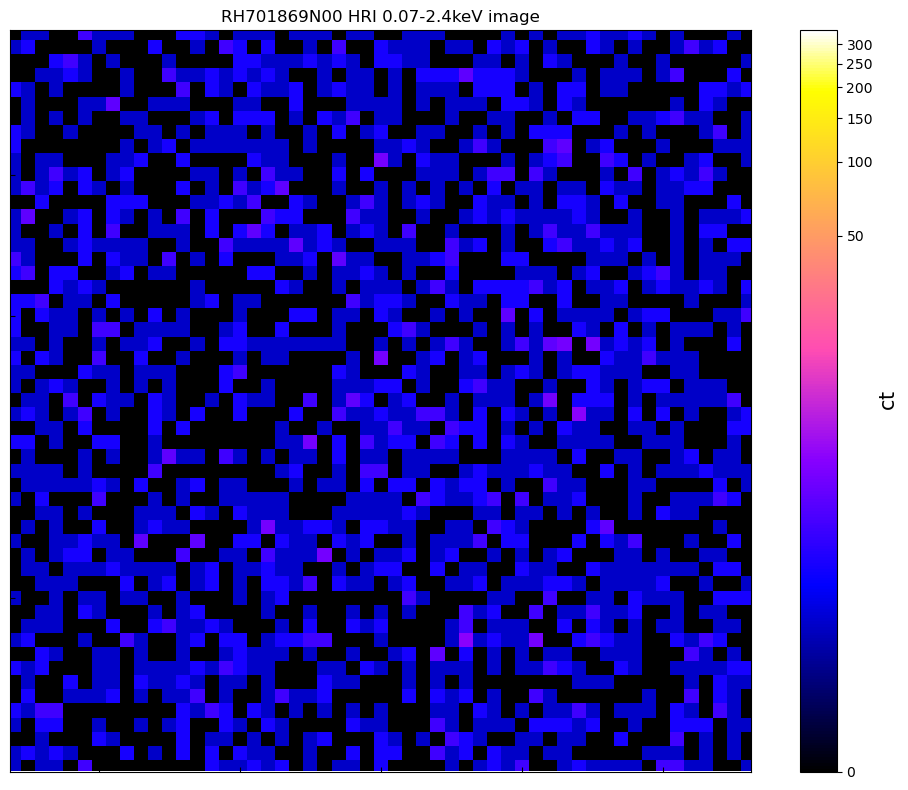





19670B


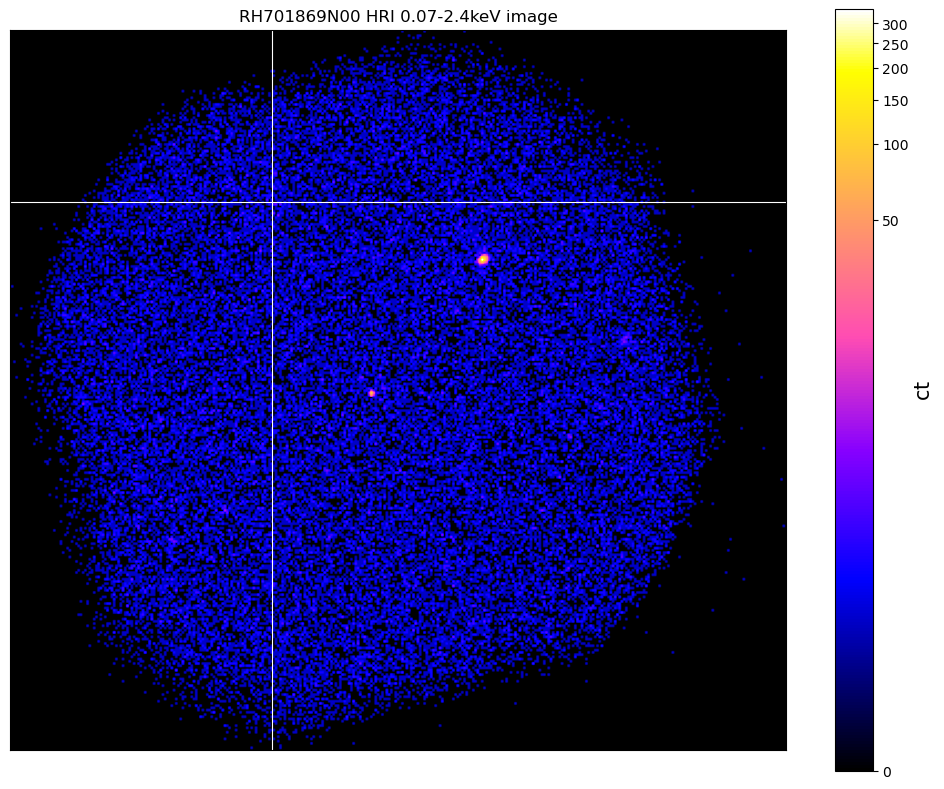

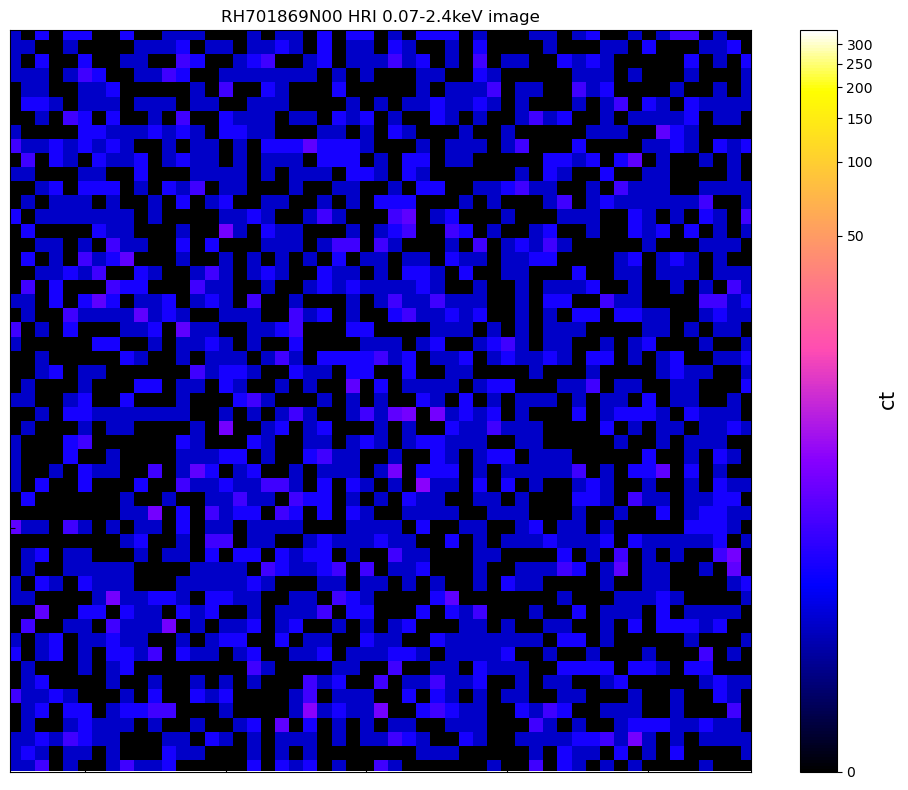





50433


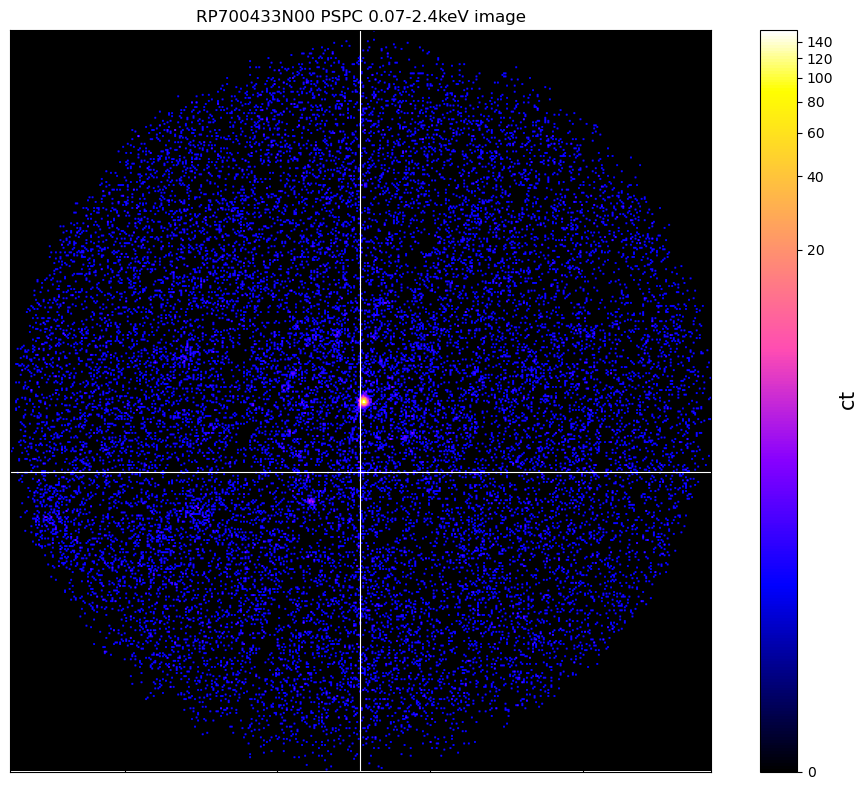

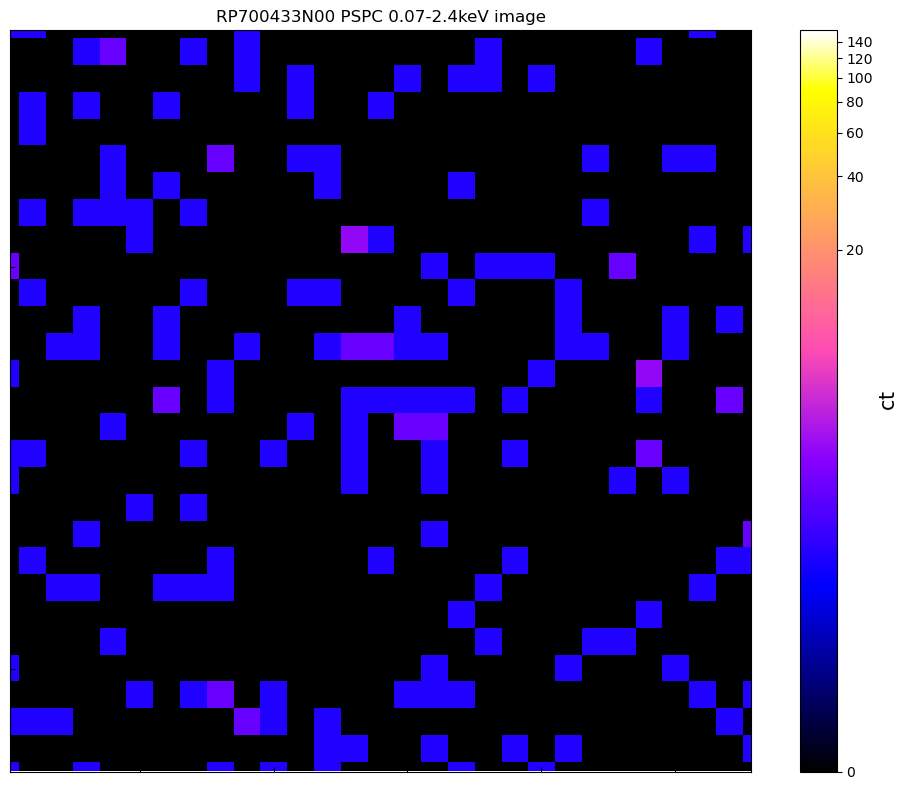





50433


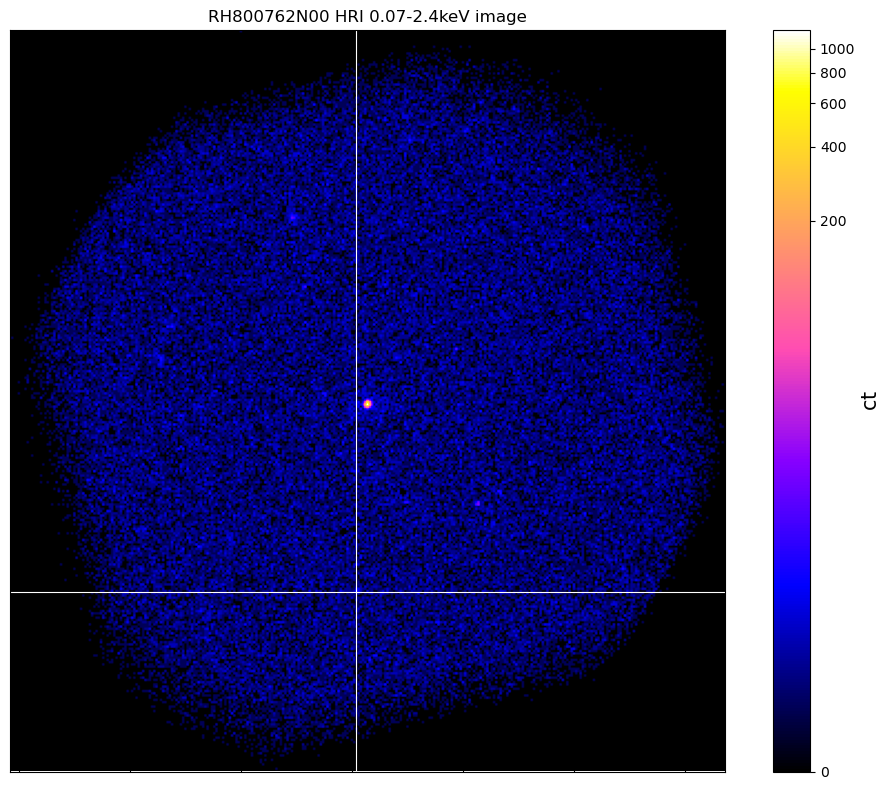

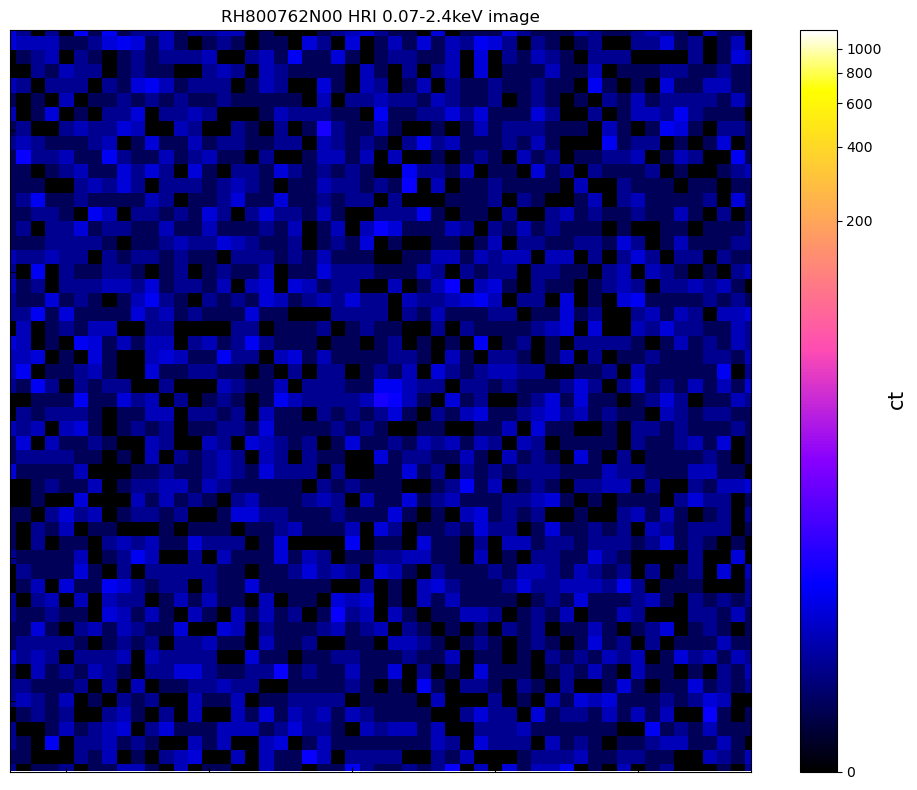





50433


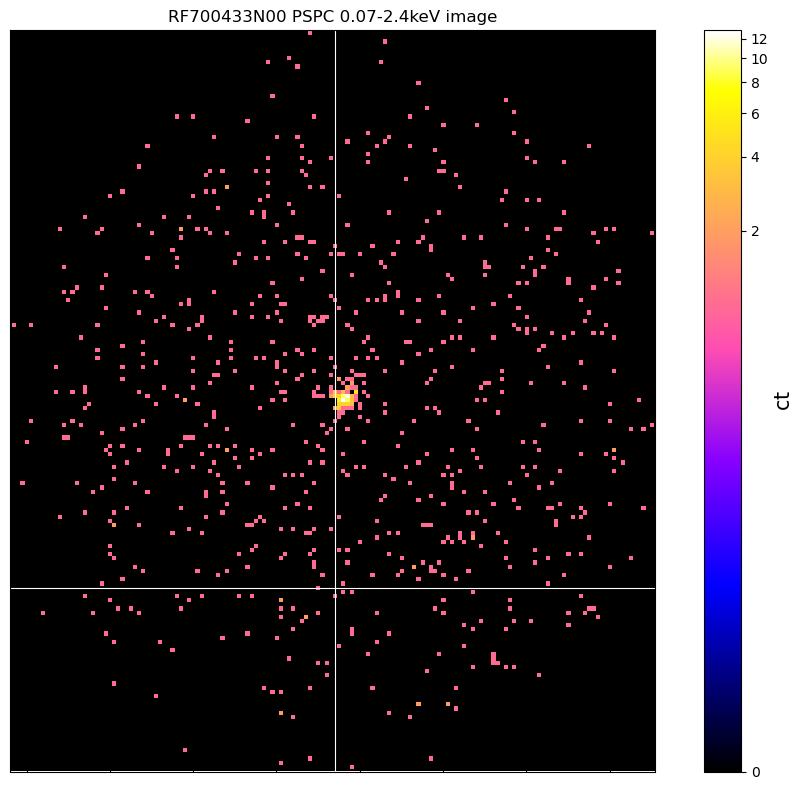

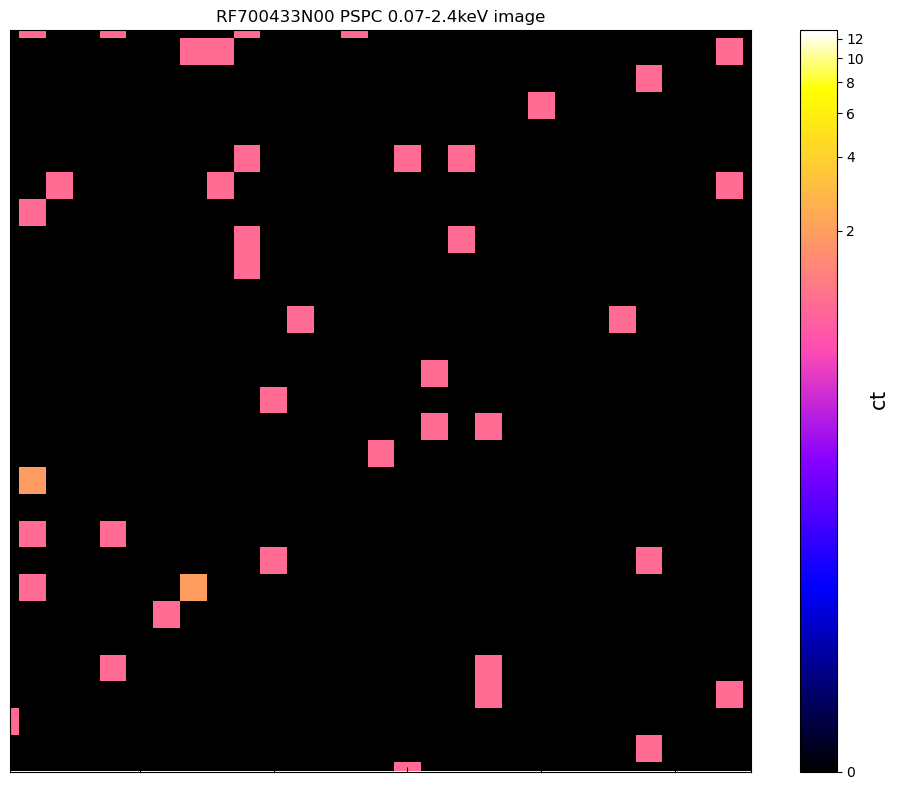

In [9]:
for oi in rp_obs_ids:
    # The top level data path for the current ROSAT pointed ObsID
    data_path = '../../data/rosat_pointed_raw/{oi}/'.format(oi=oi)
    # Finding the full FoV image file
    im_file_name = [f for f in os.listdir(data_path) if 'im' in f][0]
    
    # The full path to the full FoV image
    im_file_path = data_path + im_file_name
    
    inst = 'HRI' if im_file_name[1] == 'h' else 'PSPC'
    # Set up the XGA image, includes indexing the file name to figure out the instrument used
    cur_im = Image(im_file_path, oi, inst, '', '', '', 
                   Quantity(0.07, 'keV'), Quantity(2.4, 'keV'))
    
    # We try to convert the coordinates for each group to pixels of the current image, the majority will fail
    #  because the pixel coordinates calculated aren't valid, so the ones that don't error can be plotted
    for row_ind, row in samp.iterrows():
        # Reading out the relevant coordinate for the current group
        cur_coord = Quantity(row[['est_ra', 'est_dec']], 'deg')
        cur_z = row['redshift']
        try:
            # We try to convert the coordinate, and if that doesn't fail then we'll move onto printing
            #  the group name and plotting the image
            cur_im.coord_conv(cur_coord, 'pix')
            print(row['name'])
            im_pth = '../../outputs/figures/xray_ims/non_xmm/{n}_rosatpointed_{o}' \
                '_{i}_fov.png'.format(n=row['name'], i=inst, o=oi)
            cur_im.view(cur_coord, zoom_in=True)
            cur_im.save_view(im_pth, cur_coord, zoom_in=True)
            cur_coord_pix = cur_im.coord_conv(cur_coord, 'pix')
            half_side_len_pix = physical_rad_to_pix(cur_im, half_side_len, cur_coord, 
                                                    cur_z, cosmo).value
            im_pth = '../../outputs/figures/xray_ims/non_xmm/{n}_rosatpointed_{o}_{i}_'\
                '{sl}.png'.format(n=row['name'], i=inst, sl=str(half_side_len*2).replace(' ', ''), o=oi)
            # We also make a nice zoomed-in cutout, with a side length equal to half_side_len x 2
            cur_im.view(manual_zoom_xlims=[cur_coord_pix[0].value-half_side_len_pix, 
                                           cur_coord_pix[0].value+half_side_len_pix], 
                        manual_zoom_ylims=[cur_coord_pix[1].value-half_side_len_pix, 
                                           cur_coord_pix[1].value+half_side_len_pix], zoom_in=True)
            cur_im.save_view(im_pth, 
                             manual_zoom_xlims=[cur_coord_pix[0].value-half_side_len_pix, 
                                                cur_coord_pix[0].value+half_side_len_pix], 
                             manual_zoom_ylims=[cur_coord_pix[1].value-half_side_len_pix, 
                                                cur_coord_pix[1].value+half_side_len_pix], zoom_in=True)
            print('\n\n\n')
        except ValueError as err:
            pass

### ASCA

We found that ASCA had observed close to some of our groups, so we visualise them to see if they provide any useful context:

In [10]:
asca_obs_ids = os.listdir('../../data/asca_raw')
asca_obs_ids

['83063000', '83063010']

50433


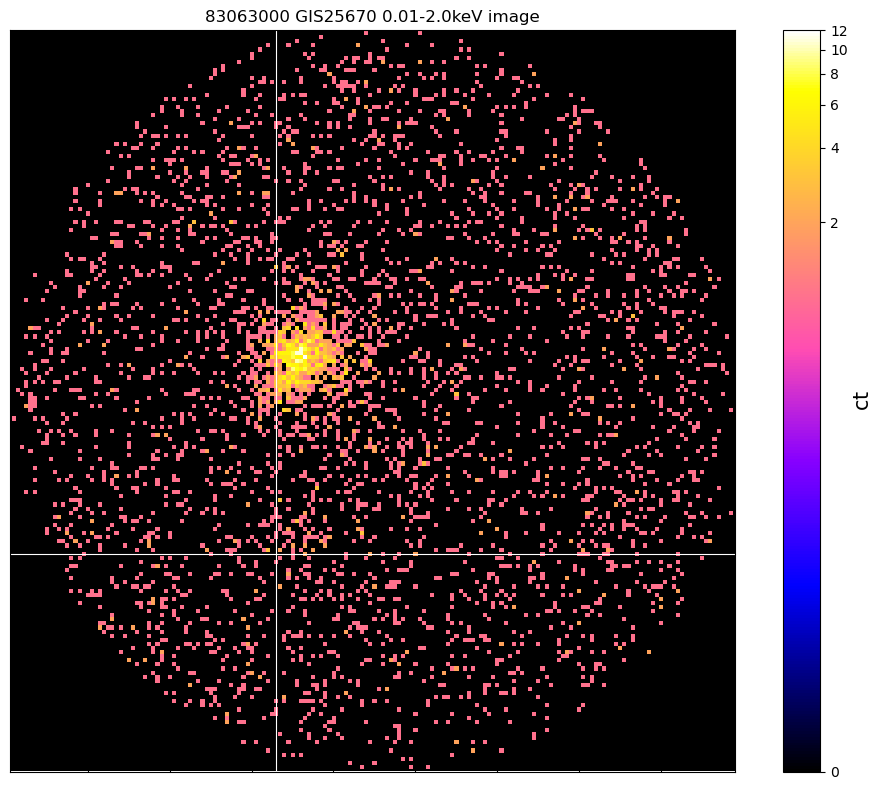

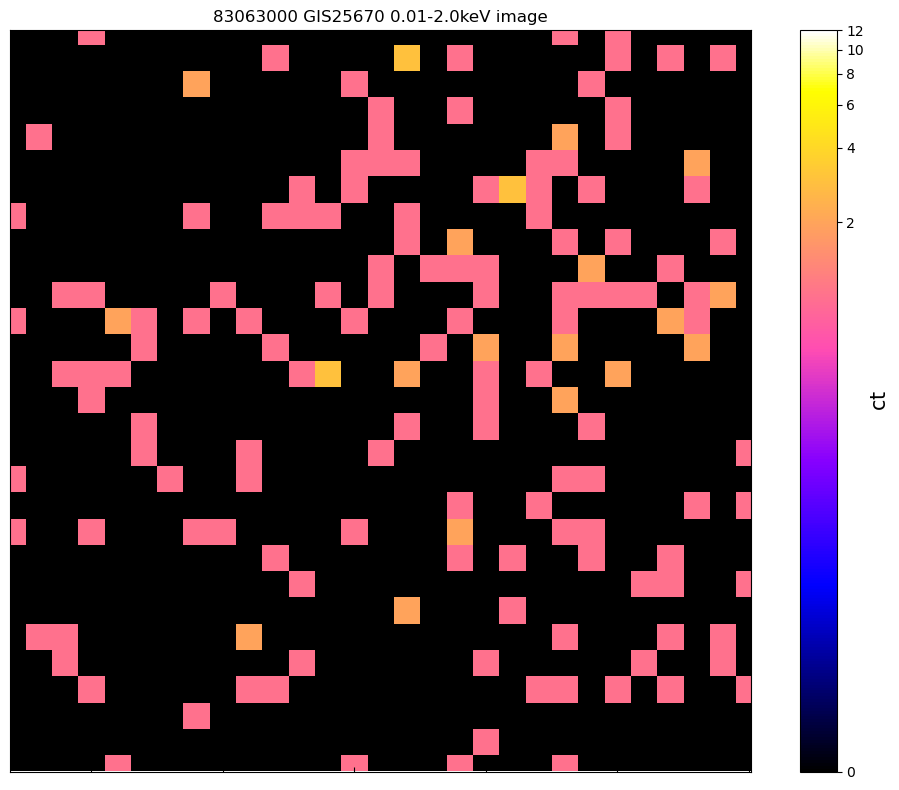





50433


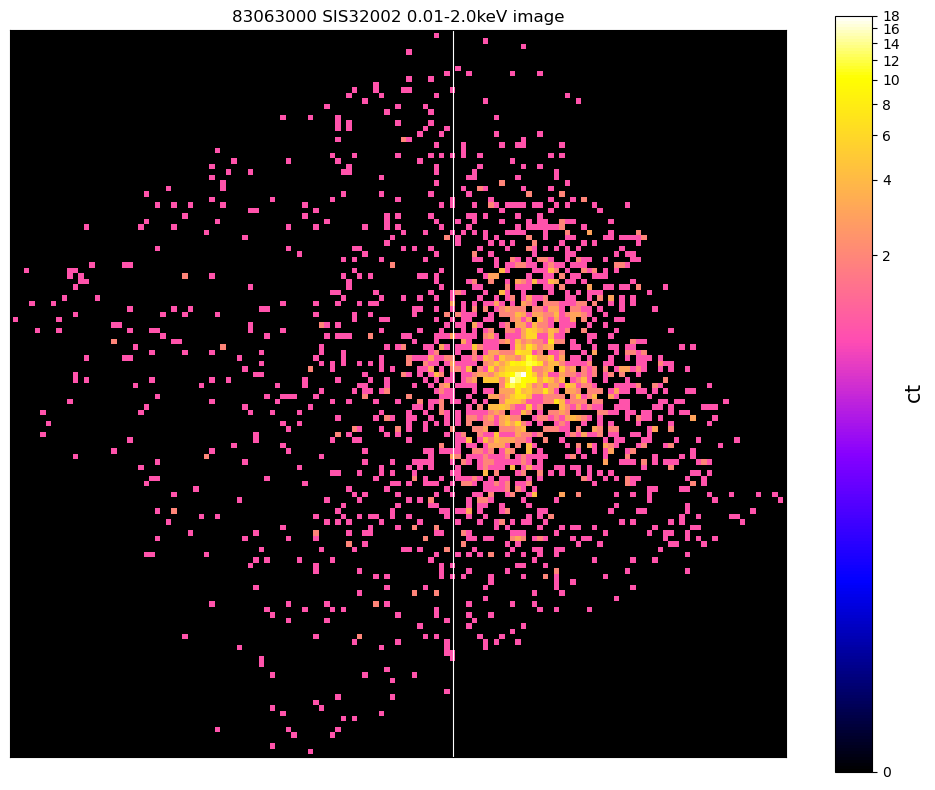

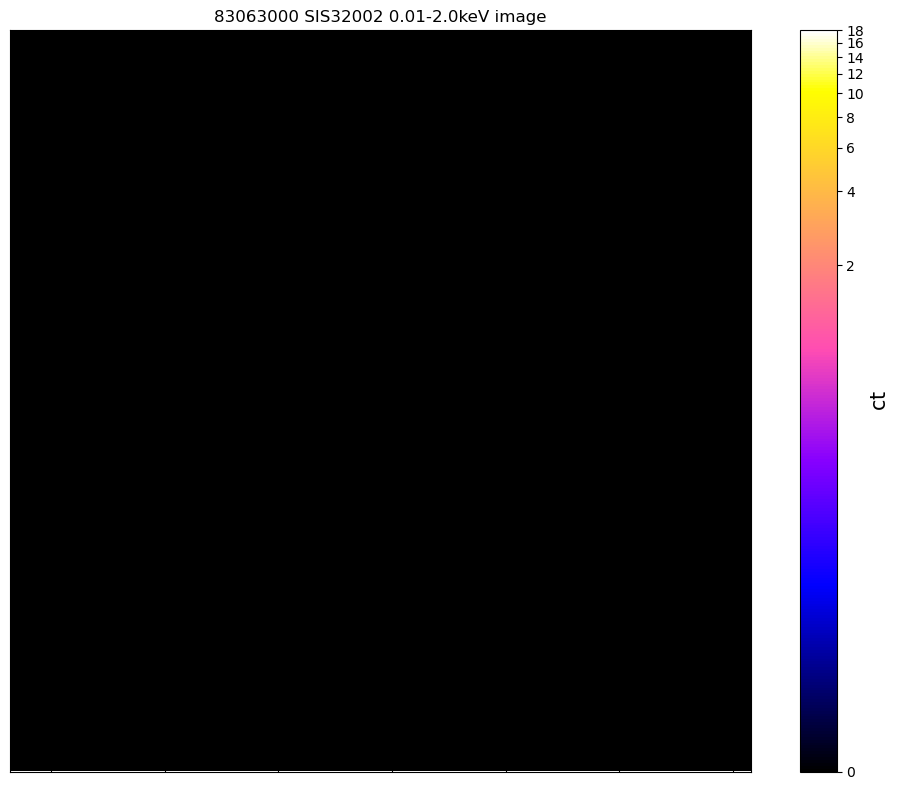





50433


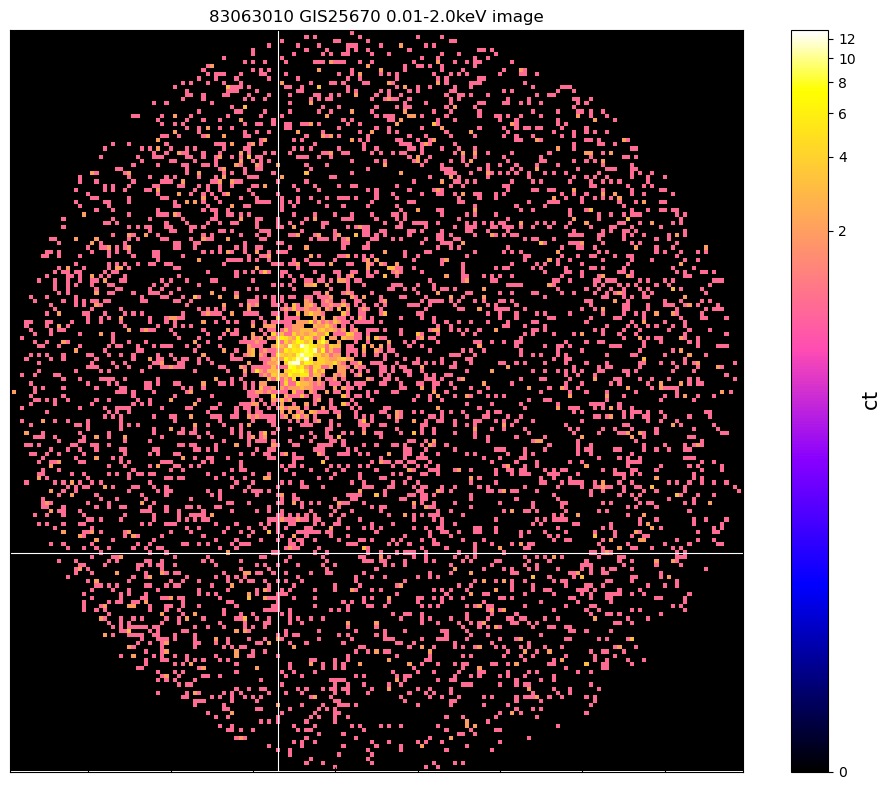

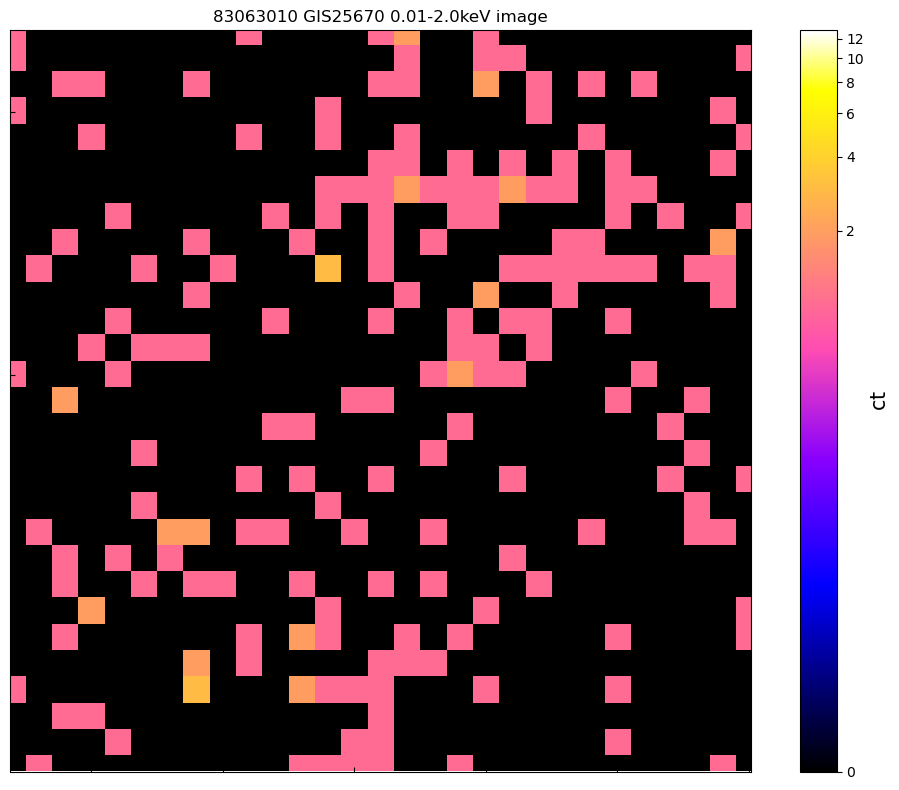





50433


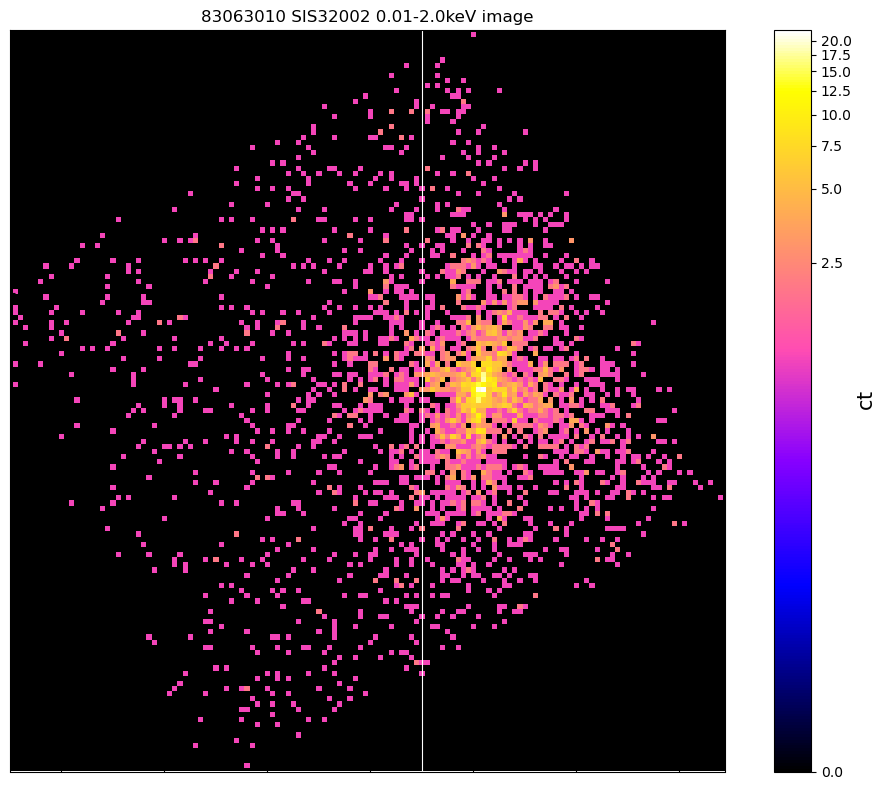

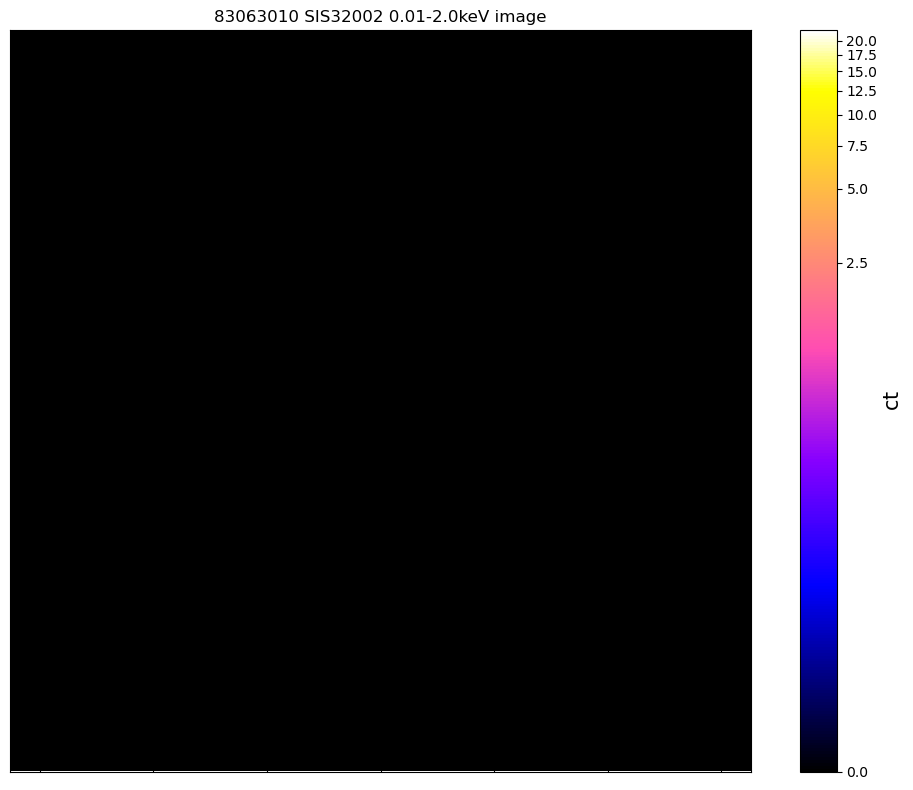

In [11]:
for oi in asca_obs_ids:
    # The image data path for the current ASCA ObsID
    im_data_path = '../../data/asca_raw/{oi}/images/ad{oi}{i}_lo.totsky.gz'
    ex_data_path = '../../data/asca_raw/{oi}/images/ad{oi}{i}.totexpo.gz'
    
    for inst in ['gis25670', 'sis32002']:
    
        # The full path to the image
        im_file_path = im_data_path.format(oi=oi, i=inst)
        ex_file_path = ex_data_path.format(oi=oi, i=inst)
        # Set up the XGA image and exposure map
        cur_im = Image(im_file_path, oi, inst, '', '', '', Quantity(0.01, 'keV'), Quantity(2.0, 'keV'))
        cur_ex = ExpMap(ex_file_path, oi, inst, '', '', '', Quantity(0.01, 'keV'), Quantity(2.0, 'keV'))
        
        # Making a RateMap out of the Image and exposure map
        cur_rt = RateMap(cur_im, cur_ex)
        
        # We try to convert the coordinates for each group to pixels of the current image, the majority will fail
        #  because the pixel coordinates calculated aren't valid, so the ones that don't error can be plotted
        for row_ind, row in samp.iterrows():
            # Reading out the relevant coordinate for the current group
            cur_coord = Quantity(row[['est_ra', 'est_dec']], 'deg')
            cur_z = row['redshift']
            try:
                # We try to convert the coordinate, and if that doesn't fail then we'll move onto printing
                #  the group name and plotting the image
                cur_im.coord_conv(cur_coord, 'pix')
                print(row['name'])
                im_pth = '../../outputs/figures/xray_ims/non_xmm/{n}_asca_{o}_{i}_fov.png'.format(n=row['name'], 
                                                                                                  i=inst,
                                                                                                  o=oi)
                cur_im.view(cur_coord, zoom_in=True)
                cur_im.save_view(im_pth, cur_coord, zoom_in=True)
                
                cur_coord_pix = cur_im.coord_conv(cur_coord, 'pix')
                half_side_len_pix = physical_rad_to_pix(cur_rt, half_side_len, cur_coord, 
                                                        cur_z, cosmo).value
                im_pth = '../../outputs/figures/xray_ims/non_xmm/{n}_asca_{i}_{o}_'\
                '{sl}.png'.format(n=row['name'], i=inst, sl=str(half_side_len*2).replace(' ', ''), o=oi)
                # We also make a nice zoomed-in cutout, with a side length equal to half_side_len x 2
                cur_im.view(manual_zoom_xlims=[cur_coord_pix[0].value-half_side_len_pix, 
                                               cur_coord_pix[0].value+half_side_len_pix], 
                            manual_zoom_ylims=[cur_coord_pix[1].value-half_side_len_pix, 
                                               cur_coord_pix[1].value+half_side_len_pix], zoom_in=True)
                cur_im.save_view(im_pth, 
                                 manual_zoom_xlims=[cur_coord_pix[0].value-half_side_len_pix, 
                                                    cur_coord_pix[0].value+half_side_len_pix], 
                                 manual_zoom_ylims=[cur_coord_pix[1].value-half_side_len_pix, 
                                                    cur_coord_pix[1].value+half_side_len_pix], zoom_in=True)
                print('\n\n\n')
            except ValueError as err:
                pass

### Suzaku

The Suzaku telescope had also observed close to some of our groups, so we visualise the various XIS instrument images to see if we can spot emission from our groups:

In [12]:
suzaku_obs_ids = os.listdir('../../data/suzaku_raw')
suzaku_obs_ids

['807061010', '807056010']

12833


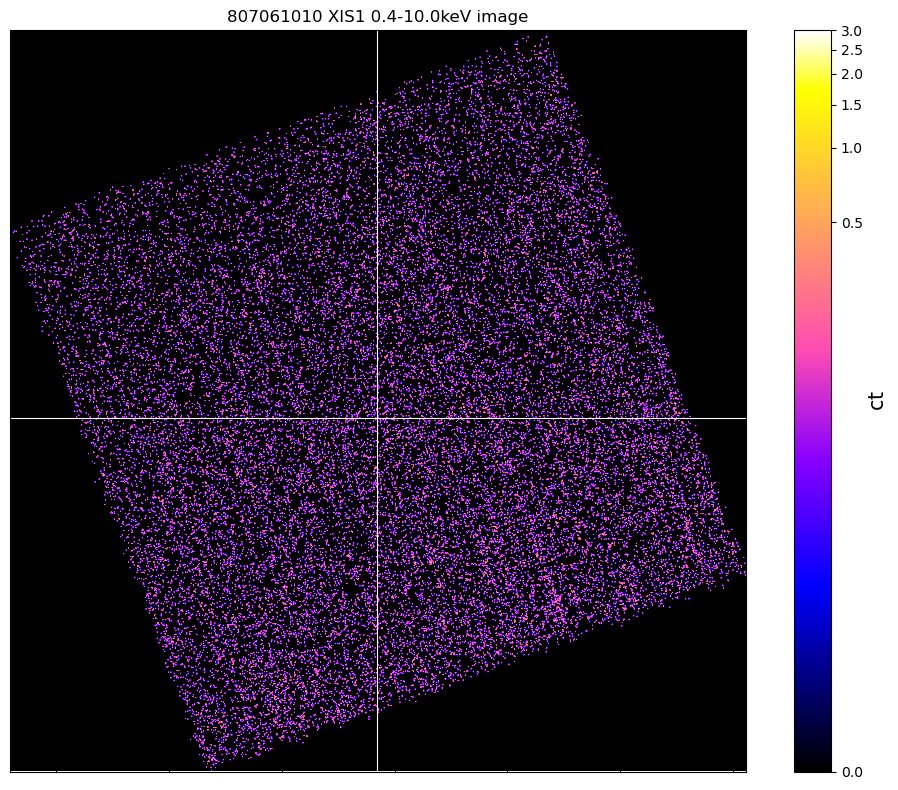

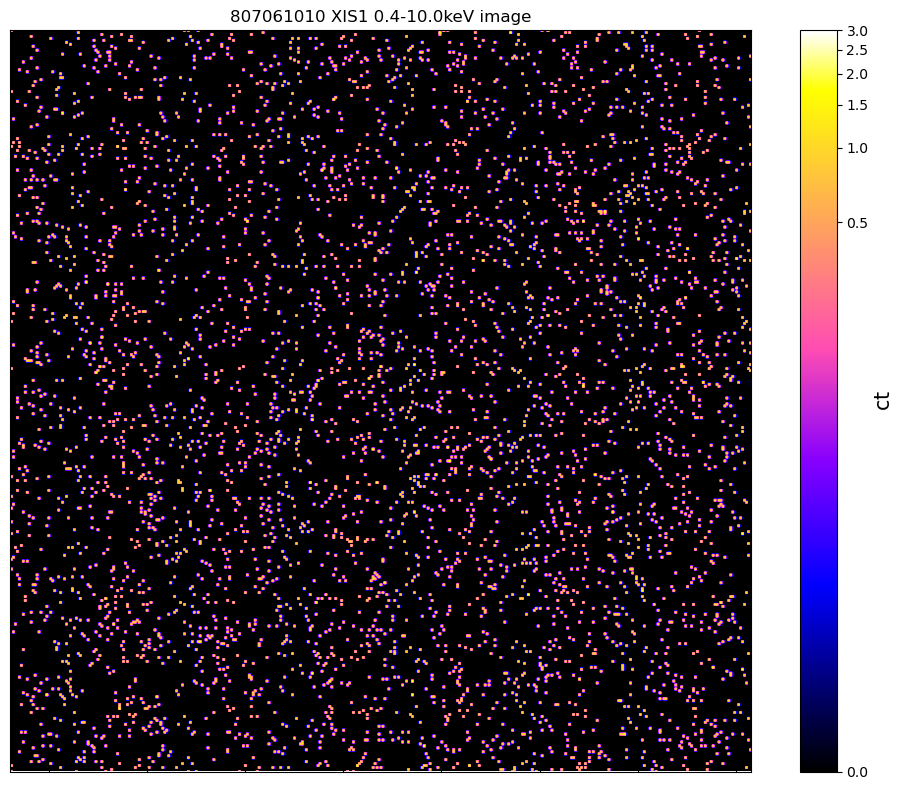





12833


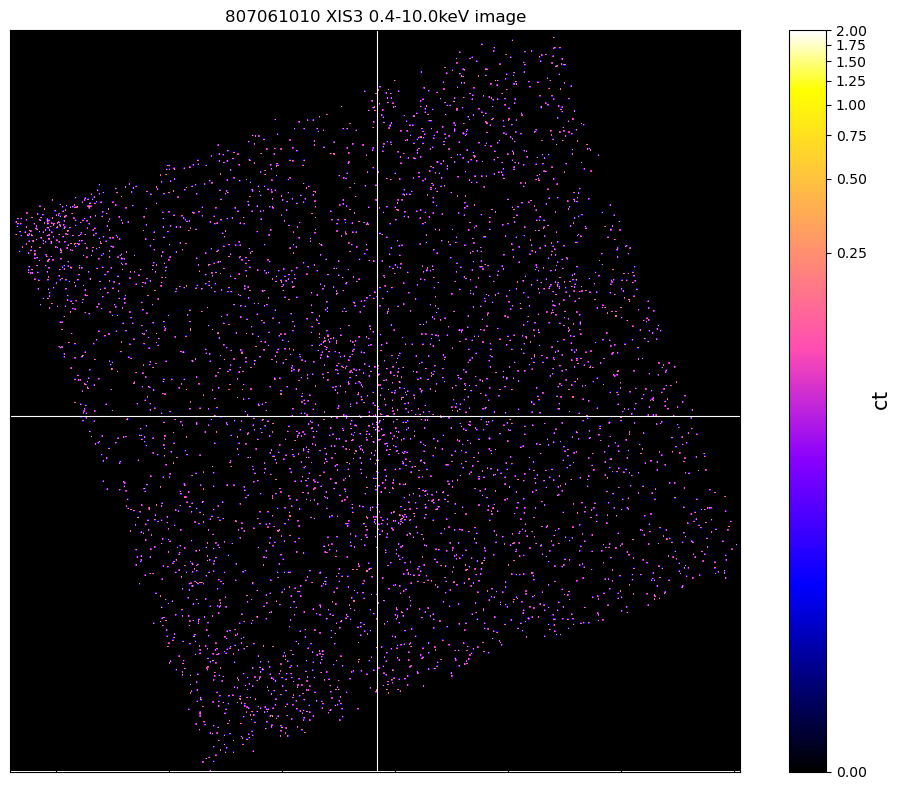

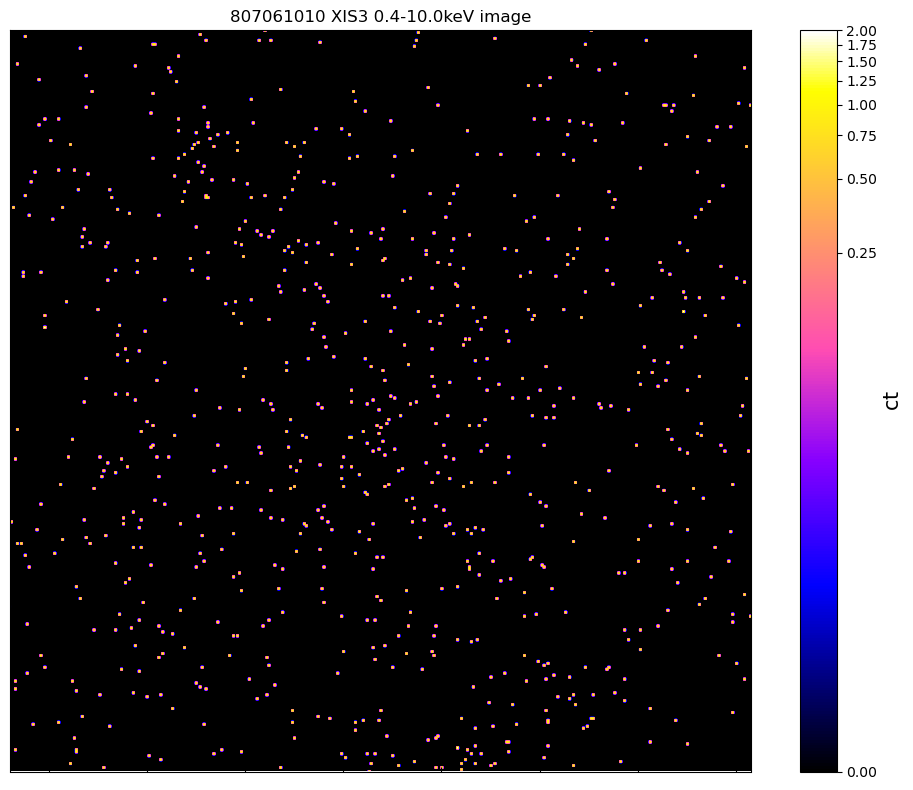





12833


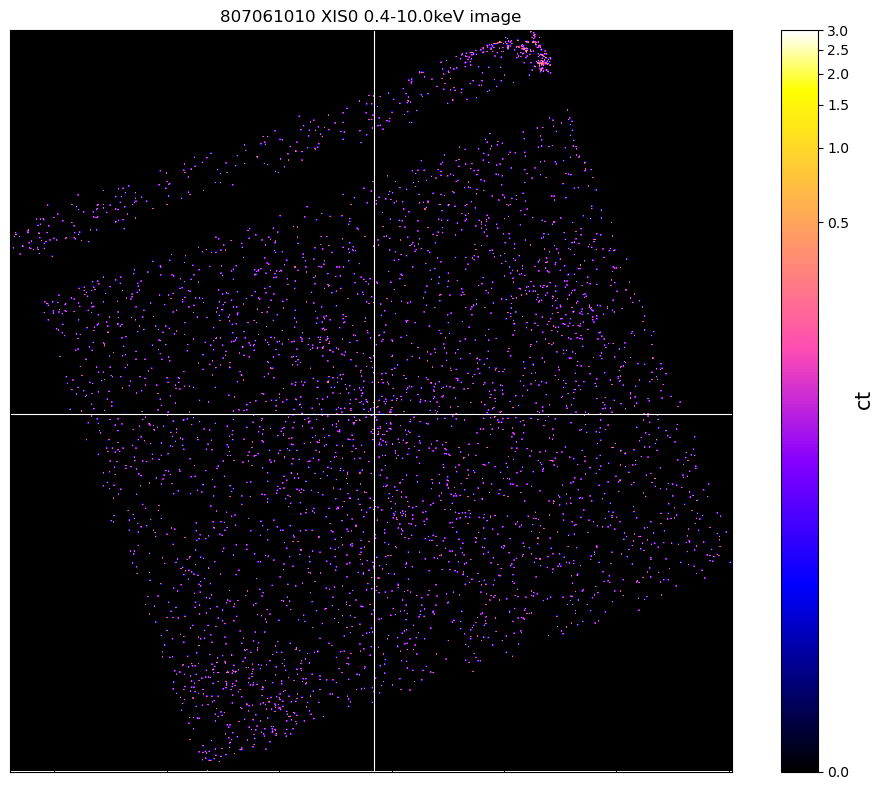

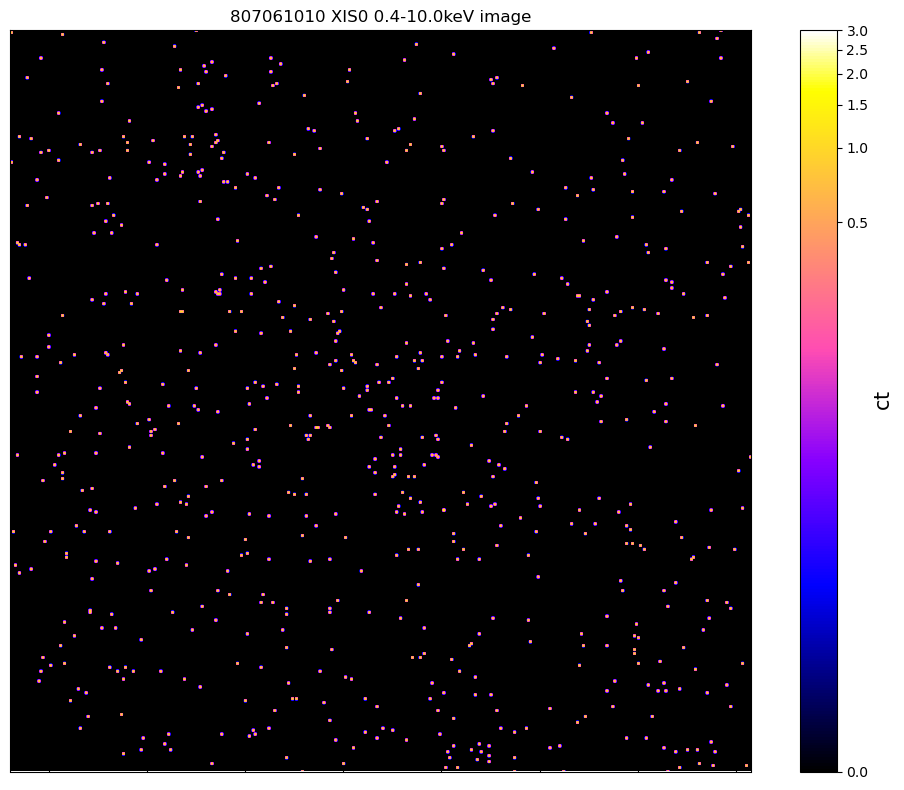





25124


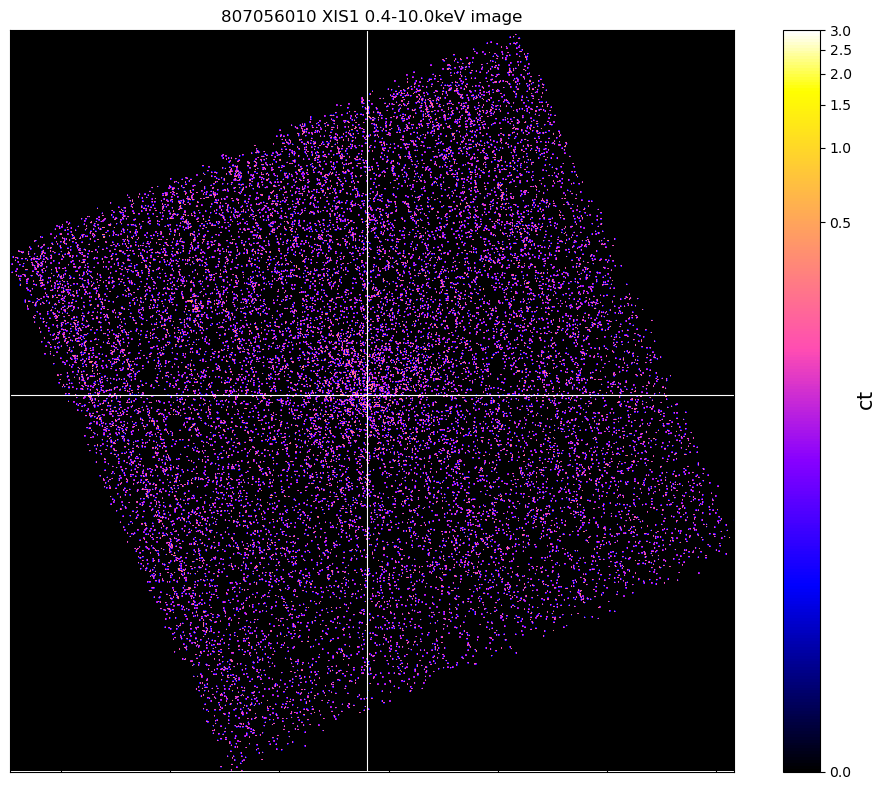

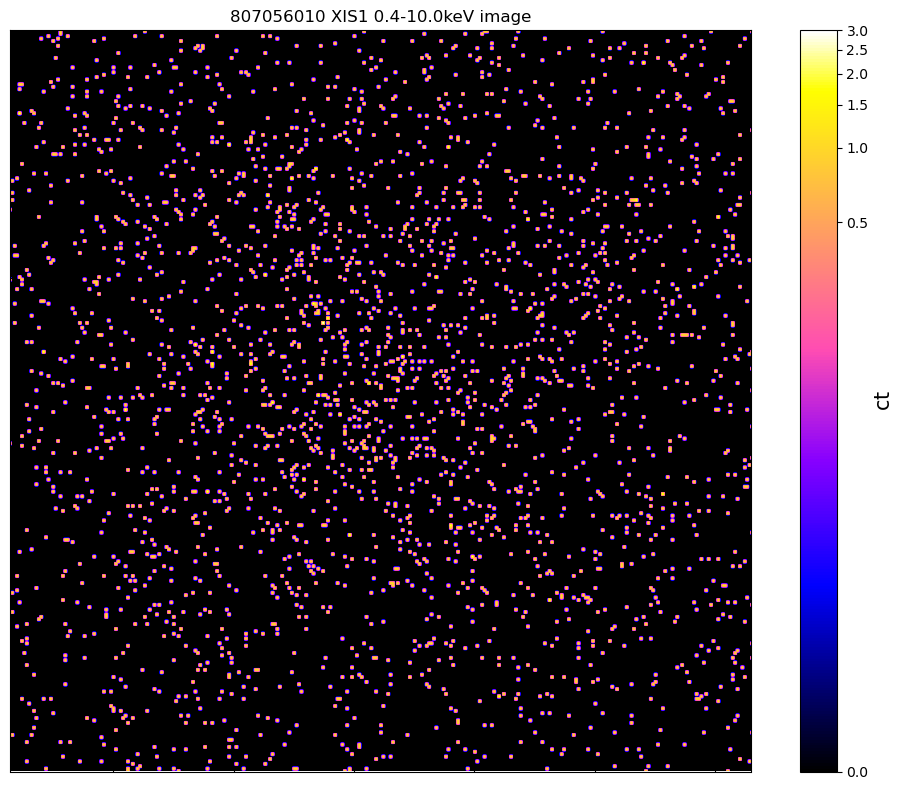





25124


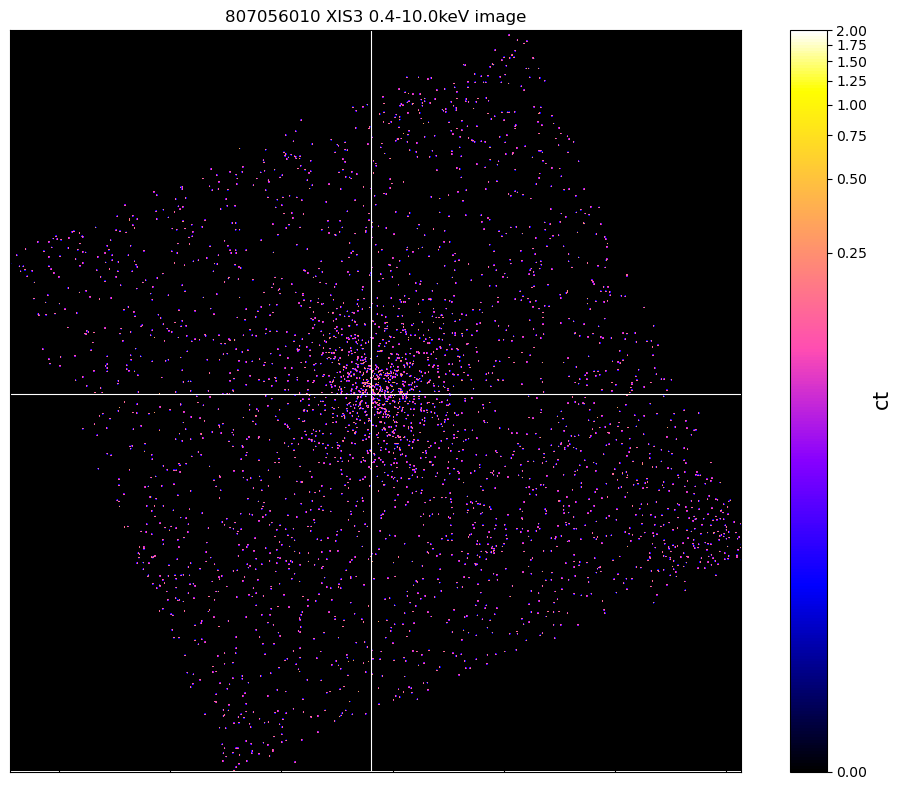

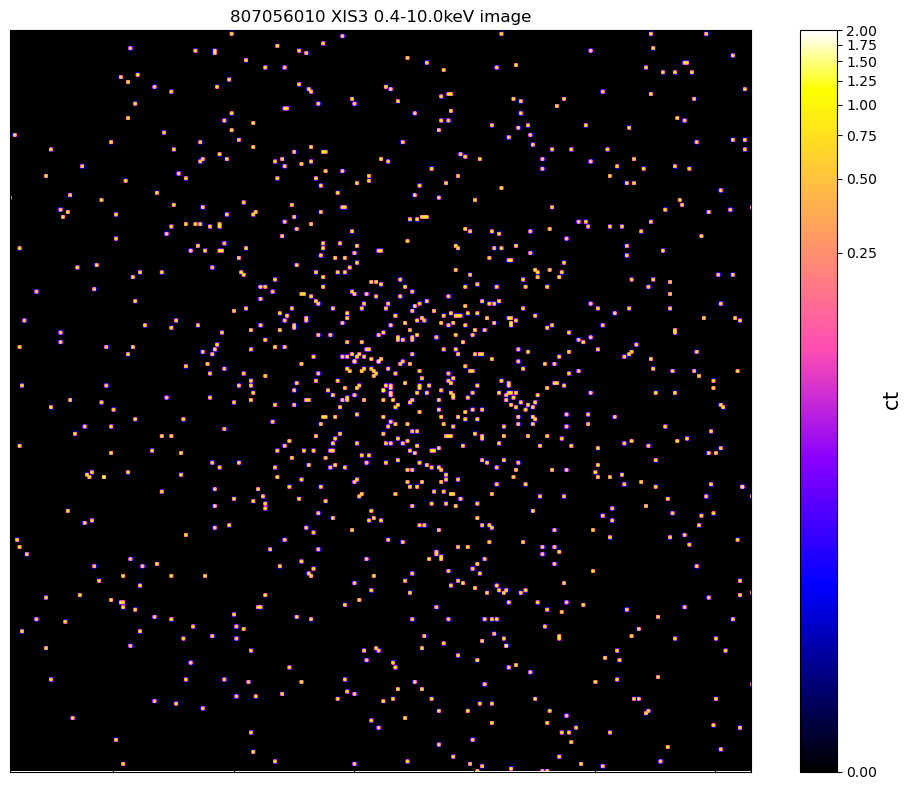





25124


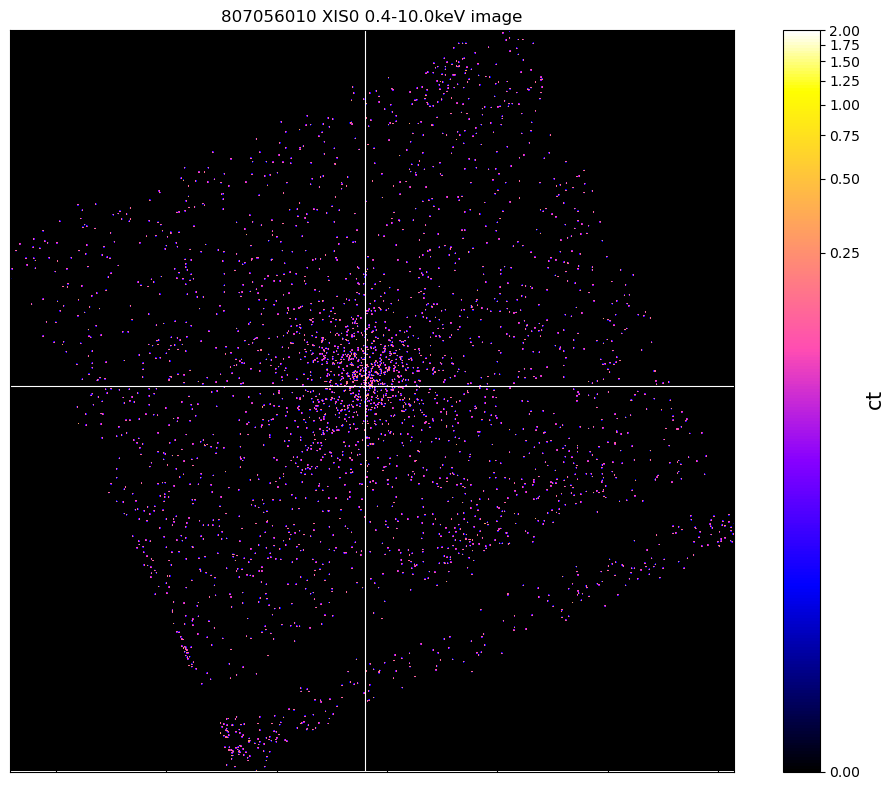

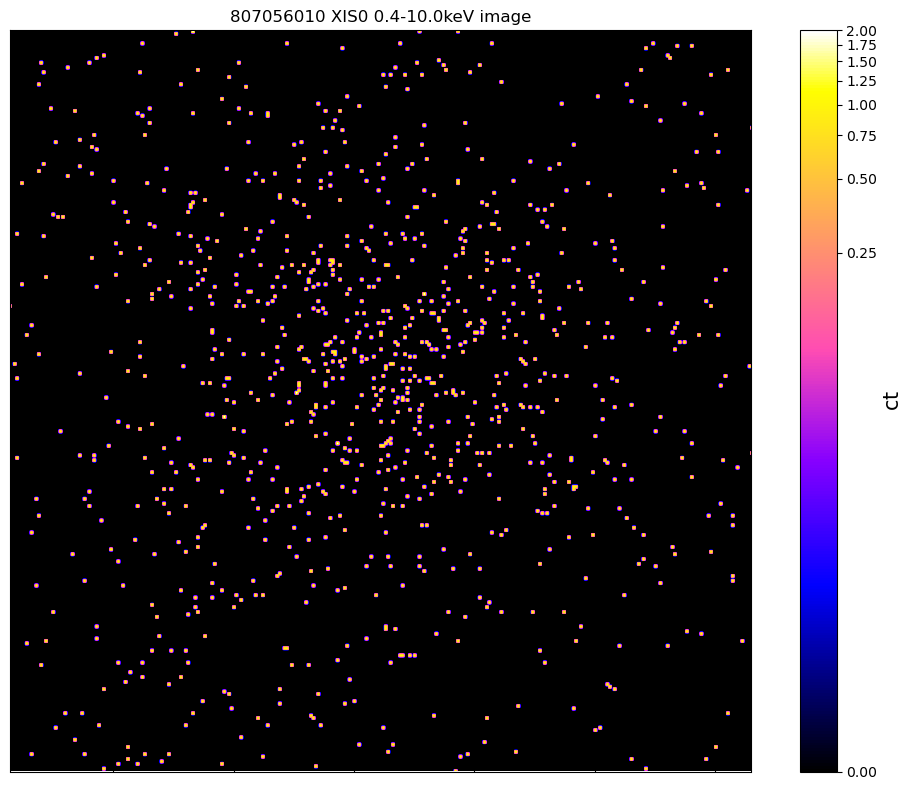

In [13]:
for oi in suzaku_obs_ids:
    # The data path for the current Suzaki ObsID
    data_path = '../../data/suzaku_raw/{oi}/xis/products/'.format(oi=oi)
    
    # Going to find all the image files this way
    im_files = [f for f in os.listdir(data_path) if 'sk.img' in f]
    
    for f in im_files:
        inst = 'XIS' + f.split('xi')[-1].split('_')[0]

        # The full path to the image
        im_file_path = data_path + f

        # Set up the XGA image
        cur_im = Image(im_file_path, oi, inst, '', '', '', Quantity(0.4, 'keV'), Quantity(10.0, 'keV'))
        
        # We try to convert the coordinates for each group to pixels of the current image, the majority will fail
        #  because the pixel coordinates calculated aren't valid, so the ones that don't error can be plotted
        for row_ind, row in samp.iterrows():
            # Reading out the relevant coordinate for the current group
            cur_coord = Quantity(row[['est_ra', 'est_dec']], 'deg')
            cur_z = row['redshift']
            try:
                # We try to convert the coordinate, and if that doesn't fail then we'll move onto printing
                #  the group name and plotting the image
                cur_im.coord_conv(cur_coord, 'pix')
                print(row['name'])
                im_pth = '../../outputs/figures/xray_ims/non_xmm/{n}_suzaku_{o}_{i}_fov.png'.format(n=row['name'], 
                                                                                                    i=inst, o=oi)
                cur_im.view(cur_coord, zoom_in=True)
                cur_im.save_view(im_pth, cur_coord, zoom_in=True)
                
                cur_coord_pix = cur_im.coord_conv(cur_coord, 'pix')
                half_side_len_pix = physical_rad_to_pix(cur_im, half_side_len, cur_coord, 
                                                        cur_z, cosmo).value
                im_pth = '../../outputs/figures/xray_ims/non_xmm/{n}_suzaku_{o}_{i}_'\
                '{sl}.png'.format(n=row['name'], i=inst, sl=str(half_side_len*2).replace(' ', ''), o=oi)
                # We also make a nice zoomed-in cutout, with a side length equal to half_side_len x 2
                cur_im.view(manual_zoom_xlims=[cur_coord_pix[0].value-half_side_len_pix, 
                                               cur_coord_pix[0].value+half_side_len_pix], 
                            manual_zoom_ylims=[cur_coord_pix[1].value-half_side_len_pix, 
                                               cur_coord_pix[1].value+half_side_len_pix], zoom_in=True)
                cur_im.save_view(im_pth, 
                                 manual_zoom_xlims=[cur_coord_pix[0].value-half_side_len_pix, 
                                                    cur_coord_pix[0].value+half_side_len_pix], 
                                 manual_zoom_ylims=[cur_coord_pix[1].value-half_side_len_pix, 
                                                    cur_coord_pix[1].value+half_side_len_pix], zoom_in=True)
                print('\n\n\n')
            except ValueError as err:
                pass

### Swift

Swift had one observation of a potentially useful length near one of our groups, but upon examination our group does not fall on the imager:

In [14]:
swift_obs_ids = os.listdir('../../data/swift_raw')
swift_obs_ids

['00035373001']

50433


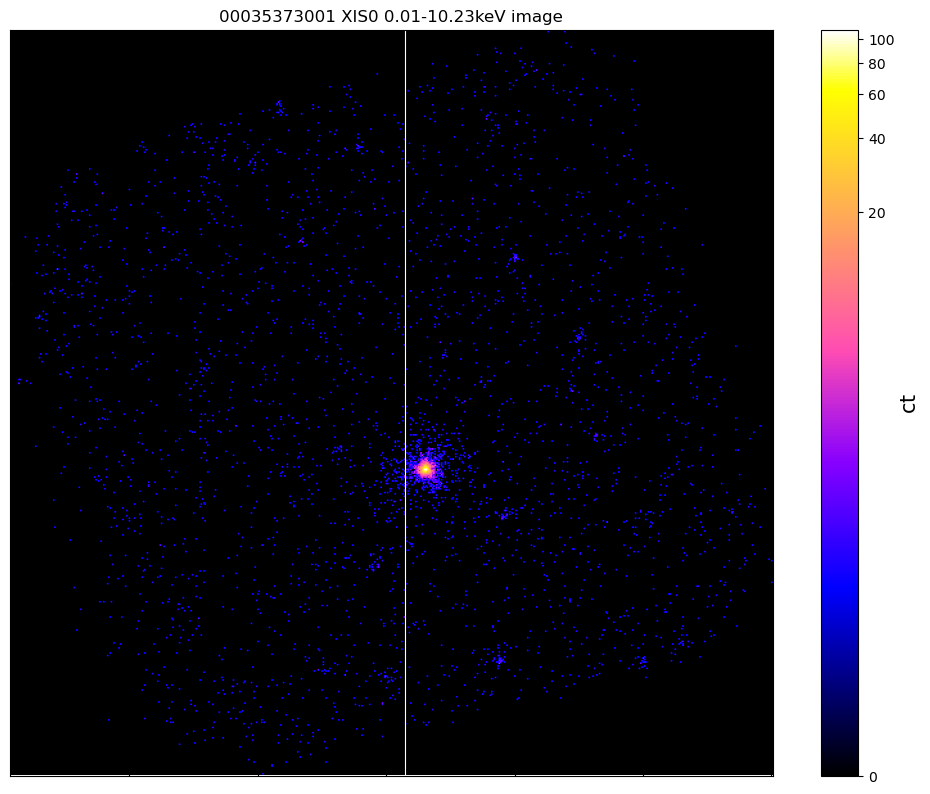

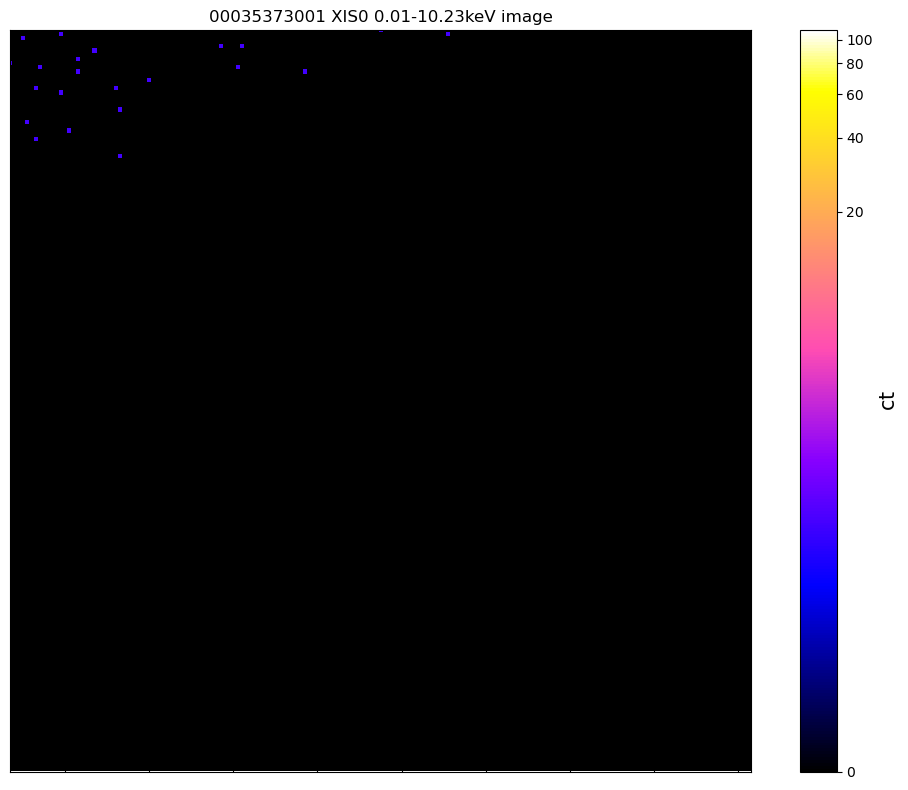

In [15]:
for oi in swift_obs_ids:
    # The image data path for the current Swift ObsID
    im_data_path = '../../data/swift_raw/{oi}/xrt/products/sw{oi}xpc_sk.img.gz'
    ex_data_path = '../../data/swift_raw/{oi}/xrt/products/sw{oi}xpc_ex.img.gz'

    # The full path to the image
    im_file_path = im_data_path.format(oi=oi)
    ex_file_path = ex_data_path.format(oi=oi)
    # Set up the XGA image and exposure map
    cur_im = Image(im_file_path, oi, inst, '', '', '', Quantity(0.01, 'keV'), Quantity(10.23, 'keV'))
    cur_ex = ExpMap(ex_file_path, oi, inst, '', '', '', Quantity(0.01, 'keV'), Quantity(10.23, 'keV'))

    # Making a RateMap out of the Image and exposure map
    cur_rt = RateMap(cur_im, cur_ex)

    # We try to convert the coordinates for each group to pixels of the current image, the majority will fail
    #  because the pixel coordinates calculated aren't valid, so the ones that don't error can be plotted
    for row_ind, row in samp.iterrows():
        # Reading out the relevant coordinate for the current group
        cur_coord = Quantity(row[['est_ra', 'est_dec']], 'deg')
        cur_z = row['redshift']
        try:
            # We try to convert the coordinate, and if that doesn't fail then we'll move onto printing
            #  the group name and plotting the image
            cur_im.coord_conv(cur_coord, 'pix')
            print(row['name'])
            im_pth = '../../outputs/figures/xray_ims/non_xmm/{n}_swift_{o}_xrt_fov.png'.format(n=row['name'], 
                                                                                               o=oi)
            cur_im.view(cur_coord, zoom_in=True)
            cur_im.save_view(im_pth, cur_coord, zoom_in=True)
            cur_coord_pix = cur_im.coord_conv(cur_coord, 'pix')
            half_side_len_pix = physical_rad_to_pix(cur_rt, half_side_len, cur_coord, 
                                                    cur_z, cosmo).value
            im_pth = '../../outputs/figures/xray_ims/non_xmm/{n}_swift_{o}_xrt_'\
                '{sl}.png'.format(n=row['name'], sl=str(half_side_len*2).replace(' ', ''), o=oi)
            # We also make a nice zoomed-in cutout, with a side length equal to half_side_len x 2
            cur_im.view(manual_zoom_xlims=[cur_coord_pix[0].value-half_side_len_pix, 
                                           cur_coord_pix[0].value+half_side_len_pix], 
                        manual_zoom_ylims=[cur_coord_pix[1].value-half_side_len_pix, 
                                           cur_coord_pix[1].value+half_side_len_pix], zoom_in=True)
            cur_im.save_view(im_pth, 
                             manual_zoom_xlims=[cur_coord_pix[0].value-half_side_len_pix, 
                                                cur_coord_pix[0].value+half_side_len_pix], 
                             manual_zoom_ylims=[cur_coord_pix[1].value-half_side_len_pix, 
                                                cur_coord_pix[1].value+half_side_len_pix], zoom_in=True)
            print('\n\n\n')
        except ValueError as err:
            pass